Pada notebook ini, saya akan membuat sebuah model machine learning untuk memprediksi data time series sebagai salah satu submission pada kelas Belajar Pengembangan Machine Learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Kali ini saya menggunakan dataset yang berisi informasi mengenai penggunaan energi dalam jangka waktu tertentu. Dataset saya unduh dari UCI Machine Learning pada tautan berikut ini: [UCI Machine Learning Repository: Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)

In [ ]:
df = pd.read_csv('energydata_complete.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [ ]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.isnull().sum().sum()

0

Pada dataset ini, kolom `Appliances` yang akan diprediksi. Pada percobaan sebelumnya, saya mengalami error karena tipe data dari `Appliances` adalah integer, maka kolom tersebut perlu saya konversi menjadi float terlebih dahulu.

In [ ]:
df['Appliances'] = df['Appliances'].astype(float)

In [ ]:
dates = df['date'].values
appliances = df['Appliances'].values

Selanjutnya saya akan membuat plot dari data time series.

Text(0.5, 1.0, 'Appliances')

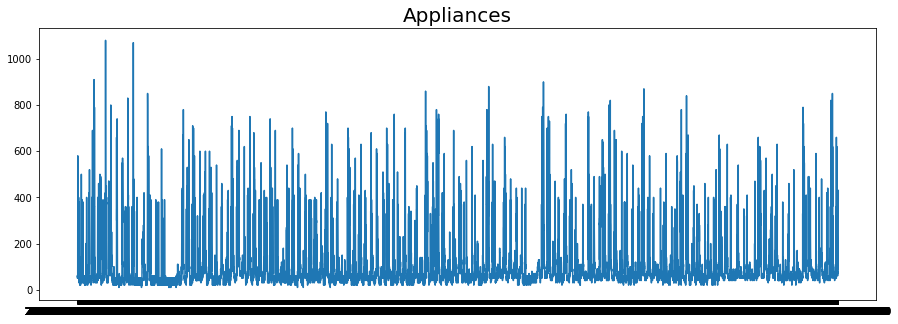

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(dates, appliances)
plt.title('Appliances', fontsize=20)

Salah satu kriteria bintang 5 pada submission adalah MAE < 10% skala data. Untuk itu saya akan mendefinisikan nilai dari skala data pada dataset ini yang nantinya akan dijadikan pertimbangan dalam menentukan maksimum MAE pada Callback.

In [ ]:
skala_data = max(df['Appliances']) - min(df['Appliances'])
skala_data

1070.0

In [ ]:
10 / 100 * skala_data

107.0

10% dari skala data adalah 107.0, maka saya memutuskan untuk membatasi MAE pada Callback sebesar 50.0 saja agar lebih aman.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 50.0 and logs.get('val_mae') < 50.0):
          print('\nmae dan val_mae telah kurang dari 10% skala data.')
          self.model.stop_training = True
callbacks = myCallback()

In [ ]:
dates_train, dates_test, appliances_train, appliances_test = train_test_split(dates, appliances, test_size=0.2, shuffle=False)

Setelah membuat callback dan membuat validation set, saya mendefinisikan fungsi `windowed_dataset` seperti yang dijelaskan pada modul kemudian menerapkannya.

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(appliances_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(appliances_test, window_size=60, batch_size=100, shuffle_buffer=1000)

Berikutnya saya akan membuat model dan melakukan training.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=SGD(learning_rate=1.0000e-04, momentum=0.9),
              metrics=['mae'])

In [ ]:
history = model.fit(train_set, validation_data=(test_set), epochs=100, callbacks=[callbacks])

Epoch 1/100
158/158 [==============================] - 18s 115ms/step - loss: 92.2181 - mae: 92.7181 - val_loss: 77.9646 - val_mae: 78.4646
Epoch 2/100
158/158 [==============================] - 18s 111ms/step - loss: 55.6938 - mae: 56.1845 - val_loss: 40.7867 - val_mae: 41.2860
Epoch 3/100
158/158 [==============================] - 18s 112ms/step - loss: 51.1558 - mae: 51.6451 - val_loss: 40.7398 - val_mae: 41.2266
Epoch 4/100
158/158 [==============================] - 18s 112ms/step - loss: 51.0132 - mae: 51.5010 - val_loss: 40.5739 - val_mae: 41.0493
Epoch 5/100
158/158 [==============================] - 17s 109ms/step - loss: 50.1904 - mae: 50.6829 - val_loss: 37.9674 - val_mae: 38.4590
Epoch 6/100
158/158 [==============================] - ETA: 0s - loss: 46.3290 - mae: 46.8211
mae dan val_mae telah kurang dari 10% skala data.
158/158 [==============================] - 18s 112ms/step - loss: 46.3290 - mae: 46.8211 - val_loss: 35.8554 - val_mae: 36.3499


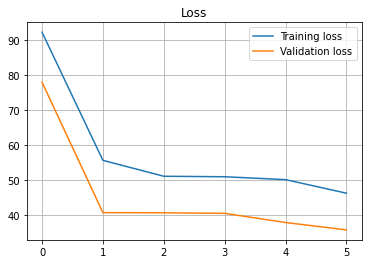

In [ ]:
plot_loss = [history.history['loss'], history.history['val_loss']]
plt.plot(range(len(plot_loss[0])), plot_loss[0], label='Training loss')
plt.plot(range(len(plot_loss[1])), plot_loss[1], label='Validation loss')
plt.title('Loss')
plt.grid(True)
plt.legend()
plt.show()

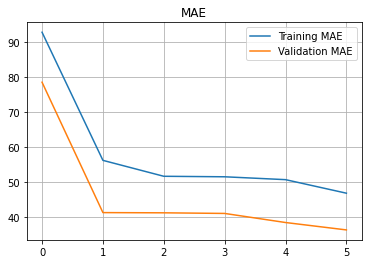

In [ ]:
plot_mae = [history.history['mae'], history.history['val_mae']]
plt.plot(range(len(plot_mae[0])), plot_mae[0], label='Training MAE')
plt.plot(range(len(plot_mae[1])), plot_mae[1], label='Validation MAE')
plt.title('MAE')
plt.grid(True)
plt.legend()
plt.show()

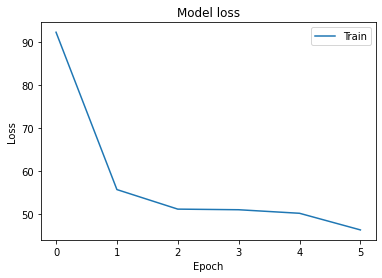

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

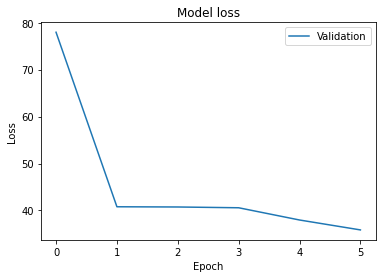

In [ ]:
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper right')
plt.show()

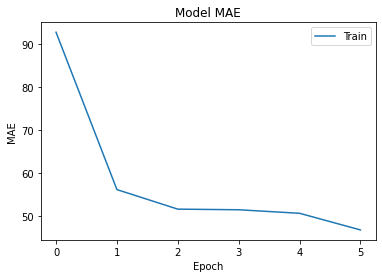

In [ ]:
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

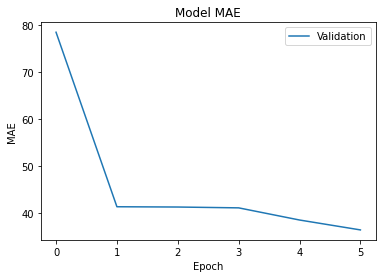

In [ ]:
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper right')
plt.show()